In [1]:
import sys
from os.path import join, abspath
from glob import glob
import numpy as np
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm, uniform
from hammer import dm

In [2]:
# import utils
root_dir = abspath(join('..'))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/6_Analisis',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import style, hdi, find_max, get_data

In [5]:
style()

In [6]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [7]:
data_baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

# $z$ variations

In [8]:
tipe = "z"
zfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'w*.hdf5'))
wfiles.sort()

In [9]:
# for model 2 (double gaussia)
dm_2_files = glob(join(join(root_data_dir, 'MCMC', 'dm_mock', tipe, 'data', "chain-2-*")))
dm_2_files.sort()
dm_2_files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-1.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-2.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-3.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/z/data/chain-2-5.npy']

In [10]:
index = 0
df = np.load(dm_2_files[index])
df.shape

(20000, 68, 33)

In [11]:
from scipy.stats import norm

rhob = df[:, :, :12]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
rhoDM = df[:, :, 24].reshape(-1)/1E-2
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

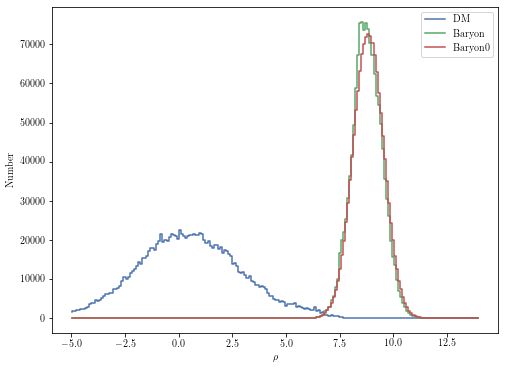

In [12]:
rho = np.linspace(-5, 14, 200)
rhoDM_num, _ = np.histogram(rhoDM, bins=rho)
rhob_num, _ = np.histogram(rhob, bins=rho)
rhob0_num, _ = np.histogram(rhob0, bins=rho)
rhomid = 0.5*(rho[1:] + rho[:-1])
# plot step
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(rhomid, rhoDM_num, label='DM')
ax.step(rhomid, rhob_num, label='Baryon')
ax.step(rhomid, rhob0_num, label='Baryon0')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Number')
ax.legend()
plt.show()

In [13]:
from scipy.stats import skewnorm
rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
rhoDM_fit = skewnorm.fit(rhoDM_sample)
rhob_sample = np.random.choice(rhob, size=2000, replace=False)
rhob_fit = skewnorm.fit(rhob_sample)
rhob0_sample = np.random.choice(rhob0, size=2000, replace=False)
rhob0_fit = norm.fit(rhob0_sample)

((1.3785428030716673, -1.3479597319111225, 3.042949204730993),
 (-0.7385854550066069, 9.19711635964847, 0.7752151489122425),
 (8.89769965852598, 0.7000581936432309))

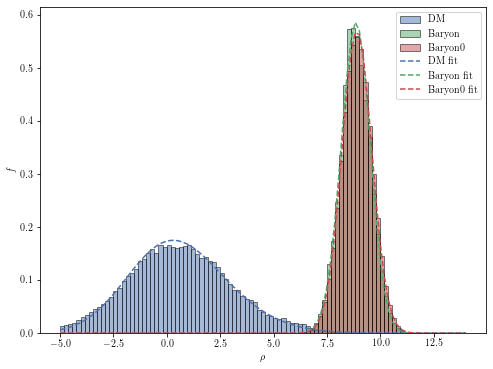

In [14]:
# plot
rho = np.linspace(-5, 14, 100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
rhoDM_fit, rhob_fit, rhob0_fit

rhoDM = 0.30 +2.41/-2.16
rhob = 8.85 +0.68/-0.69
rhob0 = 8.90 +0.71/-0.70


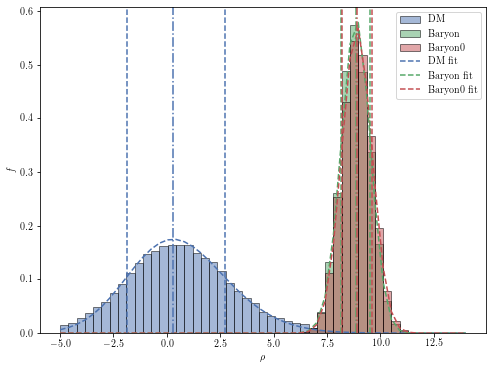

In [15]:
rhoDM_low, rhoDM_high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]

rhob_low, rhob_high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]

rhob0_low, rhob0_high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]

# plot
rho = np.linspace(-5, 14, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhoDM_mode, color='C0', ls='-.')
ax.axvline(rhob_mode, color='C1', ls='-.')
ax.axvline(rhob0_mode, color='C2', ls='-.')
ax.axvline(rhoDM_low, color='C0', ls='--')
ax.axvline(rhoDM_high, color='C0', ls='--')
ax.axvline(rhob_low, color='C1', ls='--')
ax.axvline(rhob_high, color='C1', ls='--')
ax.axvline(rhob0_low, color='C2', ls='--')
ax.axvline(rhob0_high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhoDM = {rhoDM_mode:.02f} +{rhoDM_high-rhoDM_mode:.02f}/-{rhoDM_mode-rhoDM_low:.02f}')
print(f'rhob = {rhob_mode:.02f} +{rhob_high-rhob_mode:.02f}/-{rhob_mode-rhob_low:.02f}')
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low:.02f}')

rhob0 = 8.89 +0.71/-0.71


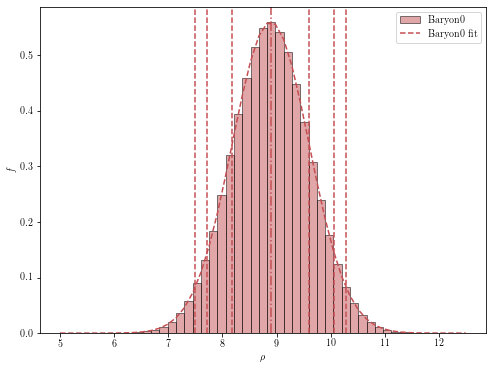

In [16]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# mode
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]
# find 
sigma_1 = 68.268949/100
sigma_2 = 90/100
sigma_3 = 95/100
rhob0_low = {}
rhob0_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=sigma, res=1E3, min=5, max=13)
    rhob0_low[i] = low
    rhob0_high[i] = high
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhob0_mode, color='C2', ls='-.')
for i in range(3):
    ax.axvline(rhob0_low[i], color='C2', ls='--')
    ax.axvline(rhob0_high[i], color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

In [17]:
from tqdm import tqdm

rhoDM_modes = []
rhoDM_errs = []
rhob_modes = []
rhob_errs = []

for index in tqdm(range(len(dm_2_files))):
    df = np.load(dm_2_files[index])
    rhob = df[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df[:, :, 24].reshape(-1)/1E-2
    print("fitting...")
    rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
    rhoDM_fit = skewnorm.fit(rhoDM_sample)
    rhob_sample = np.random.choice(rhob, size=2000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)

    print("calculating HDI...")
    rhoDM_low = {}
    rhoDM_high = {}
    rhob_low = {}
    rhob_high = {}
    for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=sigma, res=1E3, min=-5, max=15)
        rhoDM_low[i] = low
        rhoDM_high[i] = high
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=sigma, res=1E3, min=5, max=13)
        rhob_low[i] = low
        rhob_high[i] = high
    print("calculating mode")
    rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]
    rhoDM_modes.append(rhoDM_mode)
    rhoDM_errs.append({'low': rhoDM_low, 'high': rhoDM_high})
    rhob_modes.append(rhob_mode)
    rhob_errs.append({'low': rhob_low, 'high': rhob_high})

  0%|          | 0/6 [00:00<?, ?it/s]

fitting...
calculating HDI...


 17%|█▋        | 1/6 [00:02<00:11,  2.30s/it]

calculating mode
fitting...
calculating HDI...


 33%|███▎      | 2/6 [00:06<00:14,  3.52s/it]

calculating mode
fitting...
calculating HDI...


 50%|█████     | 3/6 [00:11<00:11,  3.91s/it]

calculating mode
fitting...
calculating HDI...


 67%|██████▋   | 4/6 [00:15<00:08,  4.09s/it]

calculating mode
fitting...
calculating HDI...


 83%|████████▎ | 5/6 [00:19<00:04,  4.16s/it]

calculating mode
fitting...
calculating HDI...


100%|██████████| 6/6 [00:23<00:00,  3.99s/it]

calculating mode


In [19]:
rhoDM_modes

[0.26587500000000025,
 2.2938125000000027,
 1.6359375000000016,
 1.2812500000000013,
 0.7361250000000008,
 1.4140625000000013]

In [20]:
zlevel

array([1. , 1.5, 2. , 2.5, 3. ])

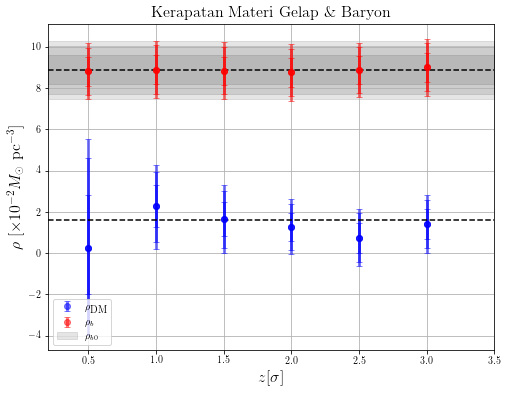

In [21]:
zlevel = np.arange(0.5, 3.1, 0.5)
zs = np.linspace(0.2, 3.5, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err['low'][i] for err in rhoDM_errs])
    high = np.array([err['high'][i] for err in rhoDM_errs])
    dm_ax = ax.errorbar(zlevel, rhoDM_modes, yerr=[rhoDM_modes-low, high-rhoDM_modes], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err['low'][i] for err in rhob_errs])
    high = np.array([err['high'][i] for err in rhob_errs])
    rhob_ax = ax.errorbar(zlevel, rhob_modes, yerr=[rhob_modes-low, high-rhob_modes], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0_ax = ax.fill_between(zs, rhob0_low[i], rhob0_high[i], color='black', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0_ax], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$'],
                  loc='lower left', fontsize=10)
# real value
ax.axhline(y=1.6, color='black', linestyle='--')
ax.set_xlabel(r'$z [\sigma]$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_xlim(zs.min(), zs.max())
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
fig.savefig(join("img", 'mock-z.pdf'), dpi=70)
plt.show()

In [94]:
# for i in range(5):
#     print(f"{rhoDM_mode[i]:.2f} & [{rhoDM_low68[i]:.2f}, {rhoDM_high68[i]:.2f}] & [{rhoDM_low90[i]:.2f}, {rhoDM_high90[i]:.2f}] & [{rhoDM_low95[i]:.2f}, {rhoDM_high95[i]:.2f}] \\\\")

In [50]:
sigma1 = 1
sigma2 = 1.5
sigma3 = 2

def plot_fit(func, fig, axes, label, zb, wb, ylim_z, ylim_w, chain, ndim, n=50000, alpha=0.2, c="C0",path=None, dpi=100, m=None):
    zmin, zmax = zb
    wmin, wmax = wb
    flat_samples = chain.reshape((-1, ndim))
    print(flat_samples.shape)
    zs = np.linspace(zmin*1.1, zmax*1.1, 100)
    ws = np.linspace(wmin*1.1, wmax*1.1, 100)
    fzs = np.empty((n, len(zs)))
    fws = np.empty((n, len(ws)))
    m = m if m is not None else 1
    for i in tqdm(range(n)):
        ind = np.random.randint(len(flat_samples))
        theta = flat_samples[ind]
        fzs[i] = func.fz(zs, theta, 1.)
        fws[i] = func.fw(ws, theta, 1.)
    fz_log_mean = np.log(fzs).mean(axis=0)+m
    fz_log_std = np.log(fzs).std(axis=0)

    fw_log_mean = np.log(fws).mean(axis=0)+m
    fw_log_std = np.log(fws).std(axis=0)

    fig, axes = fig, axes
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    for i, s in enumerate([sigma1, sigma2, sigma3]):
        if i == 0:
            axes[0].fill_between(zs, np.exp(fz_log_mean - s*fz_log_std), np.exp(
                fz_log_mean + s*fz_log_std), alpha=alpha, color=c, label=label)
        else:
            axes[0].fill_between(zs, np.exp(fz_log_mean - s*fz_log_std), np.exp(
                fz_log_mean + s*fz_log_std), alpha=alpha, color=c)
    axes[0].set_ylabel(r'$\nu(z)$ + \textup{konstan}')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_xlim(zs.min(), zs.max())
    axes[0].set_ylim(ylim_z)
    axes[0].set_yscale('log')
    axes[0].legend()

    for i, s in enumerate([sigma1, sigma2, sigma3]):
        if i == 0:
            axes[1].fill_between(ws, np.exp(fw_log_mean - s*fw_log_std),
                         np.exp(fw_log_mean + s*fw_log_std), alpha=alpha, color=c, label=label)
        else:
            axes[1].fill_between(ws, np.exp(fw_log_mean - s*fw_log_std),
                         np.exp(fw_log_mean + s*fw_log_std), alpha=alpha, color=c)
    axes[1].set_ylabel(r'$f_0(w) + \textup{konstan}$')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_xlim(ws.min(), ws.max())
    axes[1].set_ylim(*ylim_w)
    axes[1].set_yscale('log')
    axes[1].legend()
    if path is not None:
        fig.savefig(path, dpi=dpi)


In [42]:
mock_path = join(root_data_dir, 'MCMC', 'dm_mock', 'mock', 'z')
zpath = mock_path
wpath= mock_path

files = glob(join(zpath, 'z*.hdf5'))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/z/z_0.5.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/z/z_1.0.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/z/z_1.5.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/z/z_2.0.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/z/z_2.5.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/z/z_3.0.hdf5']

In [43]:
sigma = [file.split('_')[-1].split('.')[:-1] for file in files]
sigma = [float(f"{s[0]}.{s[1]}") for s in sigma]
sigma

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

In [44]:
index = 1
chain_path = join(root_data_dir, 'MCMC', 'dm_mock', 'z', 'data', f'chain-2-{index}.npy')
chain = np.load(chain_path)
chain.shape

(20000, 68, 33)

In [48]:
data = get_data(zpath, wpath, index)
zdata, wdata = data
zmid, znum, zerr = zdata
wmid, wnum, werr = wdata
zb = (zmid.min(), zmid.max())
wb = (-30, 15)

0 0.5
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1595.64it/s]


1 1.0
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1584.71it/s]


2 1.5
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1589.61it/s]


3 2.0
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1626.11it/s]


4 2.5
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1611.22it/s]


5 3.0
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1552.48it/s]


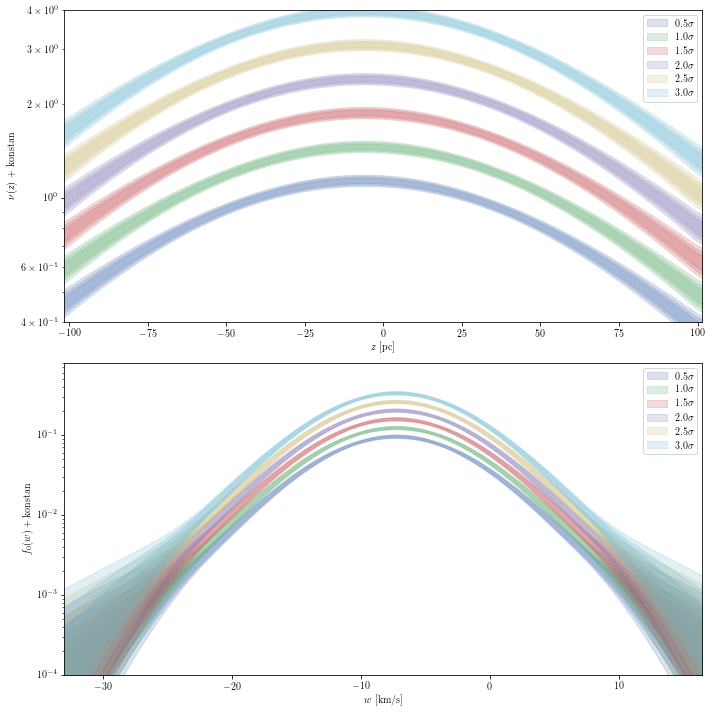

In [52]:
ndim = chain.shape[2]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for i, label in enumerate(sigma):
# for i, label in [[i, s] for i, s in enumerate(sigma)][::-1]:
    print(i, label)
    data = get_data(zpath, wpath, i)
    chain = np.load(join(root_data_dir, 'MCMC', 'dm_mock', 'z', 'data', f'chain-2-{index}.npy'))
    zdata, wdata = data
    label = r"${}\sigma$".format(label)
    plot_fit(dm, fig, axes, label, zb, wb, (4e-1, 4), (1e-4, 0.8), chain, ndim, n=10000, c=f"C{i}", 
            #  alpha=0.5, m=0)
             m=(i+1)/4)
    # break
fig.tight_layout()
fig.savefig(join("img", "fit-mock-z.pdf"), dpi=70)

# $N$

In [8]:
tipe = "n"
zfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_data_dir, 'MCMC', 'dm_mock', 'mock', tipe, 'w*.hdf5'))
wfiles.sort()

In [9]:
dm_2_files = glob(join(join(root_data_dir, 'MCMC', 'dm_mock',tipe, 'data', "chain-2-*")))
dm_2_files.sort()
dm_2_files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-1.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-2.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-3.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/n/data/chain-2-5.npy']

In [11]:
index = 0
df = np.load(dm_2_files[index])
df.shape

(20000, 68, 33)

In [12]:
from scipy.stats import norm

rhob = df[:, :, :12]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
rhoDM = df[:, :, 24].reshape(-1)/1E-2
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

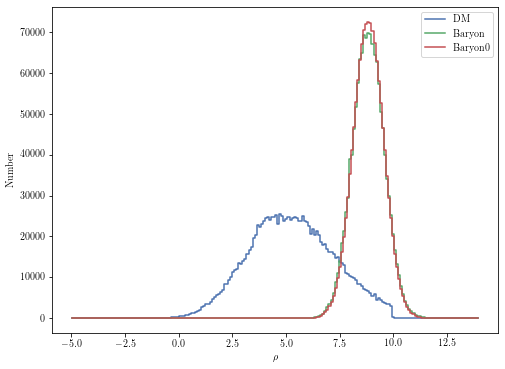

In [13]:
rho = np.linspace(-5, 14, 200)
rhoDM_num, _ = np.histogram(rhoDM, bins=rho)
rhob_num, _ = np.histogram(rhob, bins=rho)
rhob0_num, _ = np.histogram(rhob0, bins=rho)
rhomid = 0.5*(rho[1:] + rho[:-1])
# plot step
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(rhomid, rhoDM_num, label='DM')
ax.step(rhomid, rhob_num, label='Baryon')
ax.step(rhomid, rhob0_num, label='Baryon0')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Number')
ax.legend()
plt.show()

In [14]:
from scipy.stats import skewnorm
rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
rhoDM_fit = skewnorm.fit(rhoDM_sample)
rhob_sample = np.random.choice(rhob, size=2000, replace=False)
rhob_fit = skewnorm.fit(rhob_sample)
rhob0_sample = np.random.choice(rhob0, size=2000, replace=False)
rhob0_fit = norm.fit(rhob0_sample)

((7.890777727516244e-05, 5.311559539787906, 1.9627275327713187),
 (0.6150548229965789, 8.532085073595313, 0.8215465657203962),
 (8.885652399965151, 0.7143255626224743))

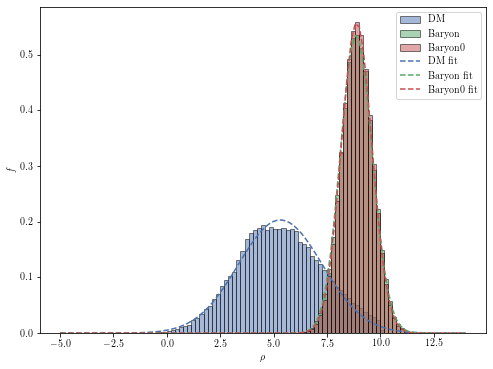

In [15]:
# plot
rho = np.linspace(-5, 14, 100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
rhoDM_fit, rhob_fit, rhob0_fit

rhoDM = 5.31 +1.96/-1.96
rhob = 8.86 +0.75/-0.74
rhob0 = 8.89 +0.72/-0.71


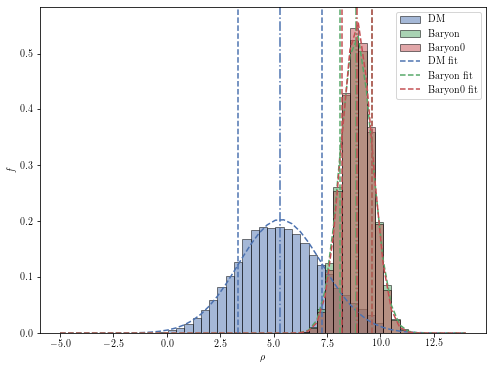

In [16]:
rhoDM_low, rhoDM_high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]

rhob_low, rhob_high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]

rhob0_low, rhob0_high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]

# plot
rho = np.linspace(-5, 14, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhoDM_mode, color='C0', ls='-.')
ax.axvline(rhob_mode, color='C1', ls='-.')
ax.axvline(rhob0_mode, color='C2', ls='-.')
ax.axvline(rhoDM_low, color='C0', ls='--')
ax.axvline(rhoDM_high, color='C0', ls='--')
ax.axvline(rhob_low, color='C1', ls='--')
ax.axvline(rhob_high, color='C1', ls='--')
ax.axvline(rhob0_low, color='C2', ls='--')
ax.axvline(rhob0_high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhoDM = {rhoDM_mode:.02f} +{rhoDM_high-rhoDM_mode:.02f}/-{rhoDM_mode-rhoDM_low:.02f}')
print(f'rhob = {rhob_mode:.02f} +{rhob_high-rhob_mode:.02f}/-{rhob_mode-rhob_low:.02f}')
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low:.02f}')

rhob0 = 8.89 +0.71/-0.71


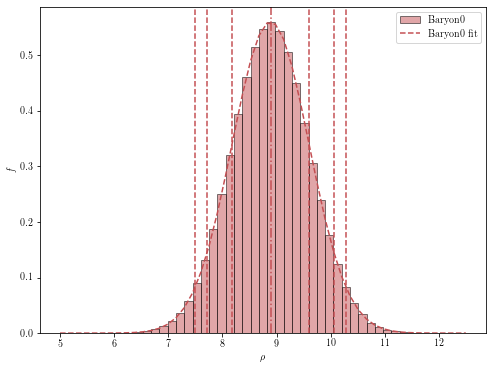

In [17]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# mode
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]
# find 
sigma_1 = 68.268949/100
sigma_2 = 90/100
sigma_3 = 95/100
rhob0_low = {}
rhob0_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=sigma, res=1E3, min=5, max=13)
    rhob0_low[i] = low
    rhob0_high[i] = high
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhob0_mode, color='C2', ls='-.')
for i in range(3):
    ax.axvline(rhob0_low[i], color='C2', ls='--')
    ax.axvline(rhob0_high[i], color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

In [18]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# mode
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]
# find 
sigma_1 = 68/100
sigma_2 = 90/100
sigma_3 = 95/100
rhob0_low = {}
rhob0_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=sigma, res=1E3, min=5, max=13)
    rhob0_low[i] = low
    rhob0_high[i] = high
# plot
rho = np.linspace(5, 12.5, 50)
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

rhob0 = 8.89 +0.71/-0.71


In [19]:
from tqdm import tqdm

rhoDM_modes = []
rhoDM_errs = []
rhob_modes = []
rhob_errs = []

for index in tqdm(range(len(dm_2_files))):
    df = np.load(dm_2_files[index])
    rhob = df[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df[:, :, 24].reshape(-1)/1E-2
    print("fitting...")
    rhoDM_sample = np.random.choice(rhoDM, size=2000, replace=False)
    rhoDM_fit = skewnorm.fit(rhoDM_sample)
    rhob_sample = np.random.choice(rhob, size=2000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)

    print("calculating HDI...")
    rhoDM_low = {}
    rhoDM_high = {}
    rhob_low = {}
    rhob_high = {}
    for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=sigma, res=1E3, min=-5, max=15)
        rhoDM_low[i] = low
        rhoDM_high[i] = high
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=sigma, res=1E3, min=5, max=13)
        rhob_low[i] = low
        rhob_high[i] = high
    print("calculating mode")
    rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]
    rhoDM_modes.append(rhoDM_mode)
    rhoDM_errs.append({'low': rhoDM_low, 'high': rhoDM_high})
    rhob_modes.append(rhob_mode)
    rhob_errs.append({'low': rhob_low, 'high': rhob_high})

  0%|          | 0/6 [00:00<?, ?it/s]

fitting...
calculating HDI...


 17%|█▋        | 1/6 [00:02<00:10,  2.18s/it]

calculating mode
fitting...
calculating HDI...


 33%|███▎      | 2/6 [00:04<00:08,  2.12s/it]

calculating mode
fitting...
calculating HDI...


 50%|█████     | 3/6 [00:06<00:06,  2.16s/it]

calculating mode
fitting...
calculating HDI...


 67%|██████▋   | 4/6 [00:08<00:04,  2.05s/it]

calculating mode
fitting...
calculating HDI...


 83%|████████▎ | 5/6 [00:10<00:02,  2.10s/it]

calculating mode
fitting...
calculating HDI...


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]

calculating mode


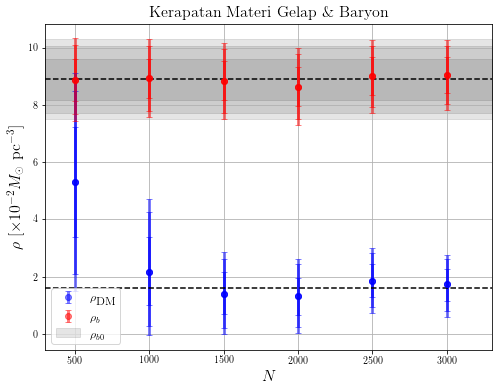

In [20]:
nlevel = np.arange(500, 3001, 500)
ns = np.linspace(300, 3300, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err['low'][i] for err in rhoDM_errs])
    high = np.array([err['high'][i] for err in rhoDM_errs])
    dm_ax = ax.errorbar(nlevel, rhoDM_modes, yerr=[rhoDM_modes-low, high-rhoDM_modes], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err['low'][i] for err in rhob_errs])
    high = np.array([err['high'][i] for err in rhob_errs])
    rhob_ax = ax.errorbar(nlevel, rhob_modes, yerr=[rhob_modes-low, high-rhob_modes], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0_ax = ax.fill_between(ns, rhob0_low[i], rhob0_high[i], color='black', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0_ax], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$'],
                  loc='lower left', fontsize=12)
# real value
ax.axhline(y=1.6, color='black', linestyle='--')
ax.set_xlabel(r'$N$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_xlim(ns.min(), ns.max())
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
fig.savefig('mock-n.pdf', dpi=300)
plt.show()

In [21]:
sigma1 = 1
sigma2 = 1.5
sigma3 = 2

def plot_fit(func, fig, axes, label, zb, wb, ylim_z, ylim_w, chain, ndim, n=50000, alpha=0.2, c="C0",path=None, dpi=100, m=None):
    zmin, zmax = zb
    wmin, wmax = wb
    flat_samples = chain.reshape((-1, ndim))
    print(flat_samples.shape)
    zs = np.linspace(zmin*1.1, zmax*1.1, 100)
    ws = np.linspace(wmin*1.1, wmax*1.1, 100)
    fzs = np.empty((n, len(zs)))
    fws = np.empty((n, len(ws)))
    m = m if m is not None else 1
    for i in tqdm(range(n)):
        ind = np.random.randint(len(flat_samples))
        theta = flat_samples[ind]
        fzs[i] = func.fz(zs, theta, 1.)
        fws[i] = func.fw(ws, theta, 1.)
    fz_log_mean = np.log(fzs).mean(axis=0)+m
    fz_log_std = np.log(fzs).std(axis=0)

    fw_log_mean = np.log(fws).mean(axis=0)+m
    fw_log_std = np.log(fws).std(axis=0)

    fig, axes = fig, axes
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    for i, s in enumerate([sigma1, sigma2, sigma3]):
        if i == 0:
            axes[0].fill_between(zs, np.exp(fz_log_mean - s*fz_log_std), np.exp(
                fz_log_mean + s*fz_log_std), alpha=alpha, color=c, label=label)
        else:
            axes[0].fill_between(zs, np.exp(fz_log_mean - s*fz_log_std), np.exp(
                fz_log_mean + s*fz_log_std), alpha=alpha, color=c)
    axes[0].set_ylabel(r'$\nu(z)$ + \textup{konstan}')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_xlim(zs.min(), zs.max())
    axes[0].set_ylim(ylim_z)
    axes[0].set_yscale('log')
    axes[0].legend()

    for i, s in enumerate([sigma1, sigma2, sigma3]):
        if i == 0:
            axes[1].fill_between(ws, np.exp(fw_log_mean - s*fw_log_std),
                         np.exp(fw_log_mean + s*fw_log_std), alpha=alpha, color=c, label=label)
        else:
            axes[1].fill_between(ws, np.exp(fw_log_mean - s*fw_log_std),
                         np.exp(fw_log_mean + s*fw_log_std), alpha=alpha, color=c)
    axes[1].set_ylabel(r'$f_0(w) + \textup{konstan}$')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_xlim(ws.min(), ws.max())
    axes[1].set_ylim(*ylim_w)
    axes[1].set_yscale('log')
    axes[1].legend()
    if path is not None:
        fig.savefig(path, dpi=dpi)


In [22]:
mock_path = join(root_data_dir, 'MCMC', 'dm_mock', 'mock', 'n')
zpath = mock_path
wpath= mock_path

files = glob(join(zpath, 'z*.hdf5'))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/n/z_000500.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/n/z_001000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/n/z_005000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/n/z_010000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/n/z_050000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/n/z_100000.hdf5']

In [28]:
n_level = [int(file.split('_')[-1].split('.')[0]) for file in files]
n_level

[500, 1000, 5000, 10000, 50000, 100000]

In [29]:
index = 1
chain_path = join(root_data_dir, 'MCMC', 'dm_mock', 'n', 'data', f'chain-2-{index}.npy')
chain = np.load(chain_path)
chain.shape

(20000, 68, 33)

In [37]:
data = get_data(zpath, wpath, index)
zdata, wdata = data
zmid, znum, zerr = zdata
wmid, wnum, werr = wdata
zb = (-150, 150)
wb = (-20, 7)

0 500
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1433.70it/s]


1 1000
(1360000, 33)


100%|██████████| 10000/10000 [00:07<00:00, 1414.42it/s]


2 5000
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1440.14it/s]


3 10000
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1435.22it/s]


4 50000
(1360000, 33)


100%|██████████| 10000/10000 [00:06<00:00, 1435.04it/s]


5 100000
(1360000, 33)


100%|██████████| 10000/10000 [00:07<00:00, 1409.82it/s]


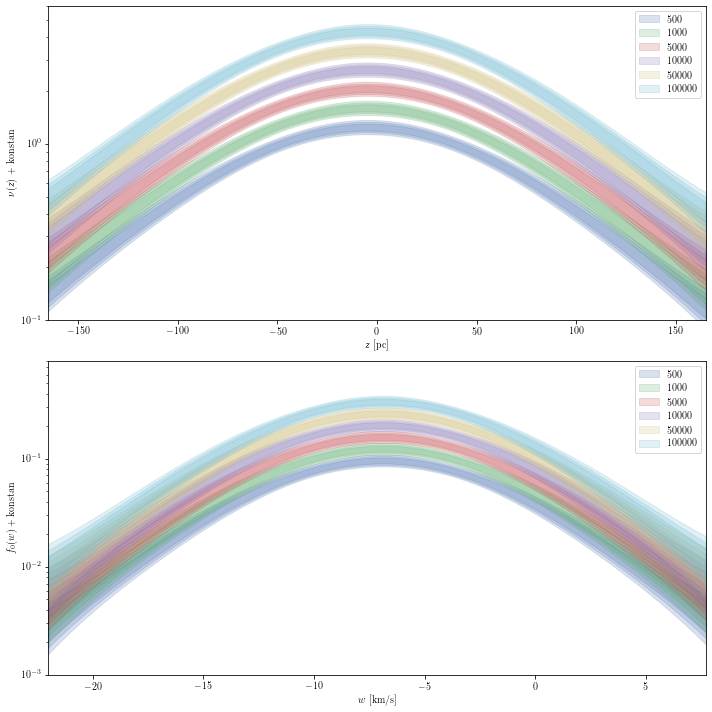

In [40]:
ndim = chain.shape[2]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for i, label in enumerate(n_level):
# for i, label in [[i, s] for i, s in enumerate(sigma)][::-1]:
    print(i, label)
    data = get_data(zpath, wpath, i)
    chain = np.load(join(root_data_dir, 'MCMC', 'dm_mock', 'n', 'data', f'chain-2-{index}.npy'))
    zdata, wdata = data
    plot_fit(dm, fig, axes, label, zb, wb, (1e-1, 6), (1e-3, 0.8), chain, ndim, n=10000, c=f"C{i}", 
            #  alpha=0.5, m=0)
             m=(i+1)/4)
    # break
fig.tight_layout()
fig.savefig(join("img", "fit-mock-n.pdf"), dpi=70)

In [20]:
# for i, n in enumerate([500, 1000, 1500, 2000, 2500, 3000]):
#     print(f"{n} & {rhoDM_mode[i]:.2f} & [{rhoDM_low68[i]:.2f}, {rhoDM_high68[i]:.2f}] & [{rhoDM_low90[i]:.2f}, {rhoDM_high90[i]:.2f}] & [{rhoDM_low95[i]:.2f}, {rhoDM_high95[i]:.2f}] \\\\")

500 & 4.98 & [2.97, 7.06] & [1.68, 8.45] & [1.07, 9.13] \\
1000 & 1.13 & [0.25, 2.04] & [-0.30, 2.65] & [-0.59, 2.93] \\
1500 & 1.12 & [0.21, 2.04] & [-0.36, 2.65] & [-0.64, 2.93] \\
2000 & 1.79 & [0.97, 2.63] & [0.44, 3.18] & [0.21, 3.46] \\
2500 & 1.27 & [0.52, 2.08] & [0.02, 2.61] & [-0.23, 2.85] \\
3000 & 2.36 & [1.60, 3.12] & [1.12, 3.63] & [0.90, 3.88] \\
